In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

In [2]:
num_iteration = 1000
mc_iteration = 2

# Loading simulated image data

In [3]:
# A_matrix = np.load("simulated_large_A_40_50.npz")
A_matrix = scipy.sparse.load_npz('simulated_large_A_20_50.npz')

x_vec = np.load("simulated_large_x_20_50.npy")
Ax = A_matrix@x_vec.flatten()

y_observation = np.random.poisson(Ax).reshape(len(A_matrix[:, 0].todense()))

print("Image vector x is of shape {}".format(np.shape(x_vec)))
print("Mixing matrix A is of shape {}".format(np.shape(A_matrix)))
print("Observation matrix Y is of shape {}".format(np.shape(y_observation)))

# Initialize x with vector of all ones.
x_init = np.ones(x_vec.shape)

Image vector x is of shape (2500,)
Mixing matrix A is of shape (2777, 2500)
Observation matrix Y is of shape (2777,)


# Gradient Ascent for poisson distributed data

In [4]:
class GradientAscent():
    def __init__(self,
                 y_observation,
                 A_matrix):
        self.y_obser = y_observation
        self.A_mat = A_matrix

    def compute_gradient(self):
        inner_term_final = 0
        if len(self.x_old.shape) > 1:
            self.x_old = np.transpose(self.x_old)
        Axn = (self.A_mat @ self.x_old)
        for i in range(len(self.y_obser)):
            inner_term_final += (((self.y_obser[i] * self.A_mat[i, :]) / Axn[i]) - self.A_mat[i, :])
        return inner_term_final

    def _get_new_x(self, x_old, lr_r=0.1):
        self.x_old = x_old
        gradient_step = self.compute_gradient()
        x_new = (x_old + lr_r*(gradient_step))
        return x_new

In [5]:
# Run GD multiple times and average estimates with new y. Randomness from poisson
estimates_mc = []
Ax = A_matrix@x_vec.flatten()

for epoc in range(mc_iteration):
    x_init = np.ones(x_vec.shape)
    
    y_observation = np.random.poisson(Ax).reshape(len(y_observation))
    GA_solver = GradientAscent(y_observation, A_matrix)
    for i in range(num_iteration):
        x_new = GA_solver._get_new_x(x_init)
        diff = np.linalg.norm(x_new - x_init)
        if (diff <= 1e-5):
            break
        x_init = x_new[0]
    estimates_mc.append(x_new)
    mse = np.linalg.norm(x_new - x_vec)
    print(f'epoc: {epoc:2d}, diff: {diff: .4E}, mse: {mse:8.4f}, step: {i:2d}')

epoc:  0, diff:  7.8078E-01, mse: 1429.4532, step: 999
epoc:  1, diff:  7.8375E-01, mse: 1422.8709, step: 999


In [6]:
avg_estimate = sum(estimates_mc)/len(estimates_mc)
mse = np.linalg.norm(avg_estimate - x_vec)
# print("Averaged Estimate:{}".format(avg_estimate))
print("Averaged estimate error:{}".format(mse))
# print("Actual x_vector simulated:{}".format(x_vec))

Averaged estimate error:1420.2535492342708


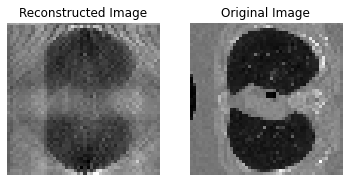

In [7]:
size = int(np.sqrt(len(x_vec)))
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_new.reshape(size, size), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_vec.reshape(size, size), cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.show()